In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sms
import statsmodels.discrete.discrete_model as sm
import os

# Data

In [3]:
data_df = pd.read_csv('data/NC-clean.csv')

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (3,5,7,23,24) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
data_df.head()

,id,state,stop_date,stop_time,location_raw,county_name,county_fips,fine_grained_location,police_department,driver_gender,...,search_type_raw,search_type,contraband_found,stop_outcome,is_arrested,search_basis,officer_id,drugs_related_stop,ethnicity,district
0,NC-2000-000001,NC,2000-01-01,00:01,NaN,NaN,NaN,Unknown,NC State Highway Patrol,M,...,Search Incident to Arrest,Incident to Arrest,False,Arrest,True,NaN,NaN,NaN,N,NaN
1,NC-2000-000002,NC,2000-01-01,00:01,NaN,NaN,NaN,Unknown,NC State Highway Patrol,M,...,NaN,NaN,False,Written Warning,False,NaN,NaN,NaN,N,NaN
2,NC-2000-000003,NC,2000-01-01,00:01,NaN,NaN,NaN,Unknown,NC State Highway Patrol,F,...,NaN,NaN,False,Written Warning,False,NaN,NaN,NaN,N,NaN
3,NC-2000-000004,NC,2000-01-01,00:02,NaN,NaN,NaN,Unknown,NC State Highway Patrol,F,...,NaN,NaN,False,Citation,False,NaN,NaN,NaN,N,NaN
4,NC-2000-000005,NC,2000-01-01,00:02,NaN,NaN,NaN,Unknown,NC State Highway Patrol,F,...,NaN,NaN,False,No Action,False,NaN,NaN,NaN,N,NaN


## Add Age Buckets

In [5]:
data_df['age_bucket'] = 0

data_df.loc[data_df.driver_age.between(15, 19), 'age_bucket'] = 1
data_df.loc[data_df.driver_age.between(20, 29), 'age_bucket'] = 2
data_df.loc[data_df.driver_age.between(30, 39), 'age_bucket'] = 3
data_df.loc[data_df.driver_age.between(40, 49), 'age_bucket'] = 4
data_df.loc[data_df.driver_age >= 50.0, 'age_bucket'] = 5

## Drop rows where gender is nan

In [6]:
data_df = data_df[~data_df.driver_gender.isnull()]

## Add stop year and only select those in 2010-2015 inclusive

In [7]:
data_df['stop_date'] = pd.to_datetime(data_df['stop_date'])

date_mask = (data_df['stop_date'] >= '2010-01-01') & (data_df['stop_date'] <= '2015-12-31')
data_df = data_df.loc[date_mask]

data_df['stop_year'] = data_df['stop_date'].dt.year

In [8]:
data_df.head()

,id,state,stop_date,stop_time,location_raw,county_name,county_fips,fine_grained_location,police_department,driver_gender,...,contraband_found,stop_outcome,is_arrested,search_basis,officer_id,drugs_related_stop,ethnicity,district,age_bucket,stop_year
5121943,NC-2010-000001,NC,2010-01-01,NaN,A7,NaN,NaN,NaN,NC State Highway Patrol,M,...,False,Citation,False,NaN,11362,NaN,N,A7,5,2010
5121944,NC-2010-000002,NC,2010-01-01,NaN,A7,NaN,NaN,NaN,NC State Highway Patrol,F,...,False,Written Warning,False,NaN,11362,NaN,N,A7,4,2010
5121945,NC-2010-000003,NC,2010-01-01,NaN,A7,NaN,NaN,NaN,NC State Highway Patrol,M,...,False,Written Warning,False,NaN,11362,NaN,N,A7,5,2010
5121946,NC-2010-000004,NC,2010-01-01,NaN,A7,NaN,NaN,NaN,NC State Highway Patrol,M,...,False,Written Warning,False,NaN,11362,NaN,N,A7,3,2010
5121947,NC-2010-000005,NC,2010-01-01,NaN,A7,NaN,NaN,NaN,NC State Highway Patrol,M,...,False,Written Warning,False,NaN,11362,NaN,N,A7,4,2010


## Add `is_citation` Label

In [9]:
data_df['is_citation'] = 0
data_df.loc[data_df.stop_outcome == "Citation", 'is_citation'] = 1

# Regression

In [10]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

TRAIN_COLS = ['driver_race', 'age_bucket', 'driver_gender', 'stop_year', 'district']

train_df = data_df[TRAIN_COLS]
train_df = train_df.dropna()

for col in TRAIN_COLS:
    if col != 'driver_race':
        le = LabelEncoder()
        train_df[col] = le.fit_transform(train_df[col])
        print(le.classes_)
        
train_df = pd.concat((train_df[['age_bucket', 'driver_gender', 'stop_year', 'district']], 
                     pd.get_dummies(train_df['driver_race'], drop_first=False)), axis=1)
train_df = (train_df-train_df.min())/(train_df.max()-train_df.min())
train_df.head()

[0 1 2 3 4 5]
['F' 'M']
[2010 2011 2012 2013 2014 2015]
['A1' 'A2' 'A3' 'A4' 'A5' 'A6' 'A7' 'A8' 'A9' 'B1' 'B2' 'B3' 'B4' 'B5'
 'B6' 'B7' 'B8' 'C1' 'C2' 'C3' 'C4' 'C5' 'C6' 'C7' 'C8' 'D1' 'D2' 'D3'
 'D4' 'D5' 'D6' 'D7' 'E1' 'E2' 'E3' 'E4' 'E5' 'E6' 'E7' 'F1' 'F2' 'F3'
 'F4' 'F5' 'G1' 'G2' 'G3' 'G4' 'G5' 'G6' 'G7' 'H1' 'H2' 'H3' 'H4' 'H5'
 'H6']


,age_bucket,driver_gender,stop_year,district,Asian,Black,Hispanic,Other,White
5121943,1.0,1.0,0.0,0.107143,0.0,0.0,0.0,0.0,1.0
5121944,0.8,0.0,0.0,0.107143,0.0,0.0,0.0,0.0,1.0
5121945,1.0,1.0,0.0,0.107143,0.0,0.0,0.0,0.0,1.0
5121946,0.6,1.0,0.0,0.107143,0.0,1.0,0.0,0.0,0.0
5121947,0.8,1.0,0.0,0.107143,0.0,0.0,0.0,0.0,1.0


In [75]:
from statsmodels.formula.api import logit

def get_log_reg(train_df, label):
    train_X = train_df.copy()
    train_X['label']= data_df[label].astype(float)

#     log_reg = logit("label ~ C(age_bucket) + C(driver_race) + C(driver_gender) + C(stop_year) + C(district)", 
#                     train_X).fit()
    log_reg = logit("label ~ age_bucket + Asian + Black + Hispanic + White" 
                    "+ driver_gender + stop_year + district", 
                    train_X).fit()
    return log_reg

### `search_conducted`

In [76]:
label = 'search_conducted'
log_reg = get_log_reg(train_df, label)
log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.037355
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  label   No. Observations:              4436141
Model:                          Logit   Df Residuals:                  4436132
Method:                           MLE   Df Model:                            8
Date:                Fri, 05 Mar 2021   Pseudo R-squ.:                 0.01832
Time:                        15:00:53   Log-Likelihood:            -1.6571e+05
converged:                       True   LL-Null:                   -1.6880e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -5.5780      0.047   -117.534      0.000      -5.671      -5.485
age_bucket       -0.7562      0.025    -30.709      0.000      -0.805      -0.708
Asian             0.0177      0.086      0.206      0.836      -0.150       0.186
Black             0.5620      0.043     12.966      0.000       0.477       0.647
Hispanic          0.8784      0.045     19.456      0.000       0.790       0.967
White             0.1661      0.043      3.884      0.000       0.082       0.250
driver_gender     0.8288      0.016     53.253      0.000       0.798       0.859
stop_year         0.0352      0.018      1.964      0.050    7.02e-05       0.070
district          0.0114      0.021      0.535      0.592      -0.030       0.053
=================================================================================
"""

In [78]:
train_X = train_df.copy()
train_X['pred'] = log_reg.predict(train_X)

for race in ['Asian', 'Black', 'Hispanic', 'Other', 'White']:
    race_df = train_X[train_X[race] == 1]
    print(race, ' mean : %.3f' %race_df['pred'].mean())
    
print('')
print("Hispanic VS White: ", np.abs(log_reg.params['Hispanic']/log_reg.params['White']))
print("Black VS White: ", np.abs(log_reg.params['Black']/log_reg.params['White']))

Asian  mean : 0.005
Black  mean : 0.008
Hispanic  mean : 0.012
Other  mean : 0.005
White  mean : 0.005

Hispanic VS White:  5.289609523135403
Black VS White:  3.384309571576296


### `is_arrested`

In [79]:
label = 'is_arrested'
log_reg = get_log_reg(train_df, label)
log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.059891
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  label   No. Observations:              4436141
Model:                          Logit   Df Residuals:                  4436132
Method:                           MLE   Df Model:                            8
Date:                Fri, 05 Mar 2021   Pseudo R-squ.:                 0.01659
Time:                        15:02:58   Log-Likelihood:            -2.6569e+05
converged:                       True   LL-Null:                   -2.7017e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -4.3223      0.031   -139.994      0.000      -4.383      -4.262
age_bucket       -0.5600      0.018    -30.272      0.000      -0.596      -0.524
Asian            -0.4159      0.065     -6.420      0.000      -0.543      -0.289
Black             0.1241      0.028      4.488      0.000       0.070       0.178
Hispanic          0.5375      0.029     18.409      0.000       0.480       0.595
White            -0.1892      0.027     -6.991      0.000      -0.242      -0.136
driver_gender     0.6691      0.011     59.572      0.000       0.647       0.691
stop_year        -0.2544      0.014    -18.638      0.000      -0.281      -0.228
district         -0.3381      0.016    -21.024      0.000      -0.370      -0.307
=================================================================================
"""

In [80]:
train_X = train_df.copy()
train_X['pred'] = log_reg.predict(train_X)

for race in ['Asian', 'Black', 'Hispanic', 'Other', 'White']:
    race_df = train_X[train_X[race] == 1]
    print(race, ' mean : %.3f' %race_df['pred'].mean())
    
print('')
print("Hispanic VS White: ", np.abs(log_reg.params['Hispanic']/log_reg.params['White']))
print("Black VS White: ", np.abs(log_reg.params['Black']/log_reg.params['White']))

Asian  mean : 0.008
Black  mean : 0.013
Hispanic  mean : 0.021
Other  mean : 0.012
White  mean : 0.009

Hispanic VS White:  2.8415753910171535
Black VS White:  0.6560283018092485


### `is_citation`

In [62]:
label = 'is_citation'
log_reg = get_log_reg(train_df, label)
log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.528254
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  label   No. Observations:              4436141
Model:                          Logit   Df Residuals:                  4436132
Method:                           MLE   Df Model:                            8
Date:                Fri, 05 Mar 2021   Pseudo R-squ.:                 0.02465
Time:                        14:57:04   Log-Likelihood:            -2.3434e+06
converged:                       True   LL-Null:                   -2.4026e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         2.4224      0.009    280.712      0.000       2.405       2.439
age_bucket       -0.2513      0.001   -273.661      0.000      -0.253      -0.250
Asian            -0.0174      0.016     -1.119      0.263      -0.048       0.013
Black            -0.3070      0.008    -38.679      0.000      -0.323      -0.291
Hispanic          0.0959      0.009     10.514      0.000       0.078       0.114
White            -0.3761      0.008    -48.637      0.000      -0.391      -0.361
driver_gender    -0.3156      0.003   -125.568      0.000      -0.320      -0.311
stop_year         0.0161      0.001     23.545      0.000       0.015       0.017
district          0.0036   7.14e-05     50.680      0.000       0.003       0.004
=================================================================================
"""

In [63]:
train_X = train_df.copy()
train_X['pred'] = log_reg.predict(train_X)

for race in ['Asian', 'Black', 'Hispanic', 'Other', 'White']:
    race_df = train_X[train_X[race] == 1]
    print(race, ' mean : %.3f' %race_df['pred'].mean())

Asian  mean : 0.823
Black  mean : 0.771
Hispanic  mean : 0.843
Other  mean : 0.825
White  mean : 0.756


# Part E

Using Coefficients:  
- Search probability: 
    - Hispanic : White ~  5.289609523135403
    - Black : White ~  3.384309571576296
- Arrest probability: 
    - Hispanic : White ~  5.289609523135403
    - Black : White ~  3.384309571576296


Using the mean predicted values from the code above, we can say:  
- Compared to white drivers, black drivers are 1.6 times more likely to get searched
- Compared to white drivers, hispanic drivers are 2.4 times more likely to get searched
- Compared to white drivers, black drivers are 2.6 times more likely to get arrested
- Compared to white drivers, hispanic drivers are 4.2 times more likely to get arrested
- Compared to white drivers, black drivers are 1.5% more likely to get cited
- Compared to white drivers, hispanic drivers are 8.7% more likely to get cited

For the relationship between age and gender: 
- The absolute value of the age and gender coeffecients are the second and third largest amongst all covariates (being black/hispanic is the largest) for all classification types
- Amonst the three classifications, age plays a bigger role in search and arrest than in citation
- Likewise, gender plays a bigger role in search and arrest than in citation
- Gender is more influential than race in predicting whether someone will be searched

# Part F

We control for variables like age, gender and location because they are variables that bias the outcome. For instance, and old women in an affluent neighborhood are empirically less likely to be pulled over than a young man in a poor neighborhood.


# Part G

We may not want to control for location because the distribution of racial groups in neighborhoods vary drastically. For instance, the citation rate of black people would be much higher in predominantly black neighborhoods but lower in predominantly white neighborhoods. Furthermore, urban vs rural communities may also have different criterion for stop and search. As such, when we want to understand system biases, it can be helpful to look at the aggregate population instead of the binned population.

# Part H

To estimate false positive rate (FPR), we assume that the rate of drivers carrying contraband is same for all racial groups. We then estimate the number of true negatives (TN) and false negatives (FN) for each racial group and calculate FPR. We try varing the rate of drivers carrying contraband from 0.005 to 0.9. For all rates, we discover that FPR is highest for Hispanic, followed by Black, then White/Asian/Other.

In [11]:
race_contraband = data_df.groupby(['driver_race', 'contraband_found', 
                                'search_conducted']).size().reset_index(name='counts')

In [12]:
rate_list = np.arange(0.005, 0.9, 0.001)
answer_dict = {}
for race in ['Asian', 'Black', 'Hispanic', 'White', 'Other']:
    answer_dict[race] = {}
    answer_dict[race]['PPV'] = []
    answer_dict[race]['FPR'] = []

In [13]:
for rate in rate_list:
    for race in ['Asian', 'Black', 'Hispanic', 'White', 'Other']:
        
        df = race_contraband[race_contraband['driver_race']==race]
        
        c_tp = df['counts'][np.logical_and(df['search_conducted']==True, 
                                           df['contraband_found']==True)].values[0]
        c_fp = df['counts'][np.logical_and(df['search_conducted']==True, 
                                           df['contraband_found']==False)].values[0]
        
        total = df['counts'].sum()
        c_fn = (rate * total) - c_tp
        c_tn = total - (c_tp + c_fp + c_fn)

        # Calculate PPV
        ppv = c_tp/(c_tp+c_fp)

        # Estimate c_tn from population data
        total = df['counts'].sum()
        c_fn = (rate * total) - c_tp
        c_tn = total - (c_tp + c_fp + c_fn)
        
        if c_tp < 0 or c_fp < 0 or c_fn < 0 or c_tn < 0:
            print(rate, race, 'negative count')
                
        # Calculate FPR
        fpr = c_fp/(c_fp+c_tn)
        
        # Save results in dict
        answer_dict[race]['PPV'].append(ppv)
        answer_dict[race]['FPR'].append(fpr)

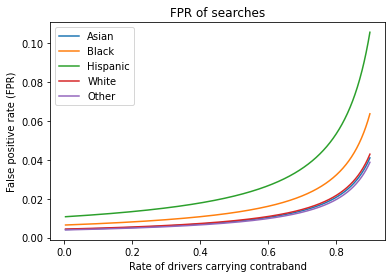

In [14]:
plt.title('FPR of searches')
plt.plot(rate_list, answer_dict['Asian']['FPR'], label='Asian')
plt.plot(rate_list, answer_dict['Black']['FPR'], label='Black')
plt.plot(rate_list, answer_dict['Hispanic']['FPR'], label='Hispanic')
plt.plot(rate_list, answer_dict['White']['FPR'], label='White')
plt.plot(rate_list, answer_dict['Other']['FPR'], label='Other')
plt.xlabel('Rate of drivers carrying contraband')
plt.ylabel('False positive rate (FPR)')
plt.legend()
plt.show()

# Part I

### 1.

For many states, `contraband_found` used for analysis in 3H is not available. Below are relevant information we gathered from the README file:

- **Arizona**: Some contraband information is available and so we define a contraband_found column in case it is useful to other researchers. But the data is messy and there are multiple ways contraband_found might be defined, and so we do not include Arizona in our contraband analysis.

- **California**: Contraband found information is only available for a small subset of searches: the raw data can tell you if a probable cause search or a consent search yielded contraband, but cannot tell you if contraband was located during a search conducted incident to arrest. We therefore exclude California from our contraband analysis.

- **Florida**: While there is some data on whether items were seized, it is not clear if these are generally seized as a result of a search, and we thus do not define a contraband_found column for consistency with other states.

- **Massachusetts**: While we define a contraband_found column in case it is useful to other researchers, it is sufficiently messy (there are multiple ways you might define contraband_found, and they are quite inconsistent) that we exclude it from our contraband analysis.

- **Wyoming**: contraband_found could potentially be derived from violation codes (drug/alcohol/weapons), but it would be less reliable and not necessarily comparable to how we defined contraband_found for other states.

- **Georgia, Iowa, Michigan, Mississippi, Montana, North Dakota, Nebraska, New Hampshire, New Jersey, New York, Nevada, Ohio, Oregon, South Dakota, Tennessee, Virginia, Wyoming**: No data

We see that there are more states with no `contraband_found` data. Even for states with data, the data seems incomplete and the definition seems largely inconsistent across states. The README file notes that there are multiple ways the variable might be defined. Consdering this inconsistency, we believe it's possible for analyses using `contraband_found` to yield different conclusions for different states. Furthermore, in states with incomplete data, the available data for `contraband_found` may suffer from some sort of survivorship bias (e.g. only contain information for cases where contraband was found).

### 2. 

For **Tennessee**, the README file notes that "There is evidence that minority drivers are labeled as white in the data. For example, see this report (http://kxan.com/investigative-story/texas-troopers-ticketing-hispanics-motorists-as-white/) from KXAN. We remapped the driver race field as provided using the 2000 surnames dataset released by the U.S. Census. See the processing script or paper for details."

First of all, the link to KXAN's report is broken. We searched for articles and believe that the following article is what the README file intended to link: https://www.kxan.com/investigations/texas-troopers-ticketing-hispanic-drivers-as-white/. We note that this article discusses DPS troopers putting minorities down as white in Texas, not Tennessee. As the content matches, we believe the README file mistakenly wrote Tennessee for Texas. In any case, this finding suggests a corruption in the data, both in the driver's age field as well as the race field. For the state(s) where this is happening, there may be errors in analyses that concerns age and/or race. For example, it may be the case that all minorities were searched. But the analysis may reveal that White was more searched than other races, due to the correlation.